In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46715,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:42785,Total threads: 8
Dashboard: http://127.0.0.1:38123/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:33333,


In [2]:
import xarray as xr
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_ADCP.nc'
ds_adcp = xr.open_dataset(profile_path)
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_CUR.nc'
ds_cur = xr.open_dataset(profile_path)
# these are hourly profiles

In [3]:
import pandas as pd
# Combine date and time into a datetime array
dates = ds_adcp['prof_YYYYMMDD'].values.astype(int)
times = ds_adcp['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_adcp = ds_adcp.assign_coords(time=('iPROF', datetimes))
# ds_adcp = ds_adcp.swap_dims({'iPROF': 'time'})
ds_adcp = ds_adcp.assign_coords(depth=('iDEPTH', ds_adcp['prof_depth'].values*-1))
# ds_adcp = ds_adcp.swap_dims({'iDEPTH': 'depth'})
ds_adcp = ds_adcp.assign_coords(lat=('iPROF', ds_adcp['prof_lat'].values))
ds_adcp = ds_adcp.assign_coords(lon=('iPROF', ds_adcp['prof_lon'].values))
# ds_adcp.set_index(lat='lat', lon='lon')
# Combine date and time into a datetime array
dates = ds_cur['prof_YYYYMMDD'].values.astype(int)
times = ds_cur['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_cur = ds_cur.assign_coords(time=('iPROF', datetimes))
# ds_cur = ds_cur.swap_dims({'iPROF': 'time'})
ds_cur = ds_cur.assign_coords(depth=('iDEPTH', ds_cur['prof_depth'].values*-1))
# ds_cur = ds_cur.swap_dims({'iDEPTH': 'depth'})
ds_cur = ds_cur.assign_coords(lat=('iPROF', ds_cur['prof_lat'].values))
ds_cur = ds_cur.assign_coords(lon=('iPROF', ds_cur['prof_lon'].values))
# ds_cur.set_index(lat='lat', lon='lon')

In [4]:
adcp_by_lon = ds_adcp.groupby('lon')
cur_by_lon = ds_cur.groupby('lon')

In [5]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import TwoSlopeNorm
import cmocean.cm as cmo
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 13
from xmitgcm import open_mdsdataset
data_dir = '/data/SO3/edavenport/tpose6/sep2012/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = ['diag_state']
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)
ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)

In [6]:
U6_140 = ds.UVEL.interp(XG=[220.0],YC=[0.0],Z=adcp_by_lon[220.0].depth.values,time=adcp_by_lon[220.0].time.values,method='linear')

U6_TAO_140 = U6_140.copy(deep=True)
U6_TAO_140.values = adcp_by_lon[220.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_140.name = 'U6_TAO_140'
U6_TAO_140 = U6_TAO_140.where(U6_TAO_140 != -9999.0)

U6_110 = ds.UVEL.interp(XG=[250.0],YC=[0.0],Z=adcp_by_lon[250.0].depth.values,time=adcp_by_lon[250.0].time.values,method='linear')

U6_TAO_110 = U6_140.copy(deep=True)
U6_TAO_110.values = adcp_by_lon[250.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_110.name = 'U6_TAO_110'
U6_TAO_110 = U6_TAO_110.where(U6_TAO_110 != -9999.0)

U6_170 = ds.UVEL.interp(XG=[190.0],YC=[0.0],Z=adcp_by_lon[190.0].depth.values,time=adcp_by_lon[190.0].time.values,method='linear')

U6_TAO_170 = U6_170.copy(deep=True)
U6_TAO_170.values = adcp_by_lon[190.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_170.name = 'U6_TAO_170'
U6_TAO_170 = U6_TAO_170.where(U6_TAO_170 != -9999.0)

U6_165E = ds.UVEL.interp(XG=[165.0],YC=[0.0],Z=adcp_by_lon[165.0].depth.values,time=adcp_by_lon[165.0].time.values,method='linear')

U6_TAO_165E = U6_165E.copy(deep=True)
U6_TAO_165E.values = adcp_by_lon[165.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_165E.name = 'U6_TAO_165E'
U6_TAO_165E = U6_TAO_165E.where(U6_TAO_165E != -9999.0)

# -------------------------

V6_140 = ds.VVEL.interp(XC=[220.0],YG=[0.0],Z=adcp_by_lon[220.0].depth.values,time=adcp_by_lon[220.0].time.values,method='linear')

V6_TAO_140 = V6_140.copy(deep=True)
V6_TAO_140.values = adcp_by_lon[220.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_140.name = 'V6_TAO_140'
V6_TAO_140 = V6_TAO_140.where(V6_TAO_140 != -9999.0)

V6_110 = ds.VVEL.interp(XC=[250.0],YG=[0.0],Z=adcp_by_lon[250.0].depth.values,time=adcp_by_lon[250.0].time.values,method='linear')

V6_TAO_110 = V6_140.copy(deep=True)
V6_TAO_110.values = adcp_by_lon[250.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_110.name = 'V6_TAO_110'
V6_TAO_110 = V6_TAO_110.where(V6_TAO_110 != -9999.0)

V6_170 = ds.VVEL.interp(XC=[190.0],YG=[0.0],Z=adcp_by_lon[190.0].depth.values,time=adcp_by_lon[190.0].time.values,method='linear')

V6_TAO_170 = V6_170.copy(deep=True)
V6_TAO_170.values = adcp_by_lon[190.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_170.name = 'V6_TAO_170'
V6_TAO_170 = V6_TAO_170.where(V6_TAO_170 != -9999.0)

V6_165E = ds.VVEL.interp(XC=[165.0],YG=[0.0],Z=adcp_by_lon[165.0].depth.values,time=adcp_by_lon[165.0].time.values,method='linear')

V6_TAO_165E = V6_165E.copy(deep=True)
V6_TAO_165E.values = adcp_by_lon[165.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_165E.name = 'V6_TAO_165E'
V6_TAO_165E = V6_TAO_165E.where(V6_TAO_165E != -9999.0)

U6_TAO_140 = U6_TAO_140.sel(time=slice('2012-09-01', None))
V6_TAO_140 = V6_TAO_140.sel(time=slice('2012-09-01', None))
U6_140 = U6_140.sel(time=slice('2012-09-01', None))
V6_140 = V6_140.sel(time=slice('2012-09-01', None))

U6_TAO_110 = U6_TAO_110.sel(time=slice('2012-09-01', None))
V6_TAO_110 = V6_TAO_110.sel(time=slice('2012-09-01', None))
U6_110 = U6_110.sel(time=slice('2012-09-01', None))
V6_110 = V6_110.sel(time=slice('2012-09-01', None))

U6_TAO_170 = U6_TAO_170.sel(time=slice('2012-09-01', None))
V6_TAO_170 = V6_TAO_170.sel(time=slice('2012-09-01', None))
U6_170 = U6_170.sel(time=slice('2012-09-01', None))
V6_170 = V6_170.sel(time=slice('2012-09-01', None))

depths = U6_TAO_140.Z.values

zMax = -35
zMin = -250
Udepthli = np.argmin(np.abs(depths - zMax))
Udepthui = np.argmin(np.abs(depths - zMin)) + 1

# crop the time series to the depths we are interested in to get rid of NaNs before computing covariance
U6_140 = U6_140[3:,Udepthli:Udepthui,0,0]
U6_TAO_140 = U6_TAO_140[3:,Udepthli:Udepthui,0,0]
U6_TAO_140 = U6_TAO_140.where(~np.isnan(U6_TAO_140),0.0)
U6_140 = U6_140.where(~np.isnan(U6_140),0.0)

V6_140 = V6_140[3:,Udepthli:Udepthui,0,0]
V6_TAO_140 = V6_TAO_140[3:,Udepthli:Udepthui,0,0]
V6_TAO_140 = V6_TAO_140.where(~np.isnan(V6_TAO_140),0.0)
V6_140 = V6_140.where(~np.isnan(V6_140),0.0)

U6_110 = U6_110[3:,Udepthli:Udepthui,0,0]
U6_TAO_110 = U6_TAO_110[3:,Udepthli:Udepthui,0,0]
U6_TAO_110 = U6_TAO_110.where(~np.isnan(U6_TAO_110),0.0)
U6_110 = U6_110.where(~np.isnan(U6_110),0.0)

V6_110 = V6_110[3:,Udepthli:Udepthui,0,0]
V6_TAO_110 = V6_TAO_110[3:,Udepthli:Udepthui,0,0]
V6_TAO_110 = V6_TAO_110.where(~np.isnan(V6_TAO_110),0.0)
V6_110 = V6_110.where(~np.isnan(V6_110),0.0)

U6_170 = U6_170[3:,Udepthli:Udepthui,0,0]
U6_TAO_170 = U6_TAO_170[3:,Udepthli:Udepthui,0,0]
U6_TAO_170 = U6_TAO_170.where(~np.isnan(U6_TAO_170),0.0)
U6_170 = U6_170.where(~np.isnan(U6_170),0.0)

V6_170 = V6_170[3:,Udepthli:Udepthui,0,0]
V6_TAO_170 = V6_TAO_170[3:,Udepthli:Udepthui,0,0]
V6_TAO_170 = V6_TAO_170.where(~np.isnan(V6_TAO_170),0.0)
V6_170 = V6_170.where(~np.isnan(V6_170),0.0)

In [7]:
# select 100 random profiles
num_profiles = 500
prof_idx = np.random.choice(U6_TAO_140.time.size, num_profiles, replace=False)
U6_TAO_140 = U6_TAO_140.isel(time=prof_idx)
V6_TAO_140 = V6_TAO_140.isel(time=prof_idx)
U6_TAO_110 = U6_TAO_110.isel(time=prof_idx)
V6_TAO_110 = V6_TAO_110.isel(time=prof_idx)
U6_TAO_170 = U6_TAO_170.isel(time=prof_idx)
V6_TAO_170 = V6_TAO_170.isel(time=prof_idx)

U6_140 = U6_140.isel(time=prof_idx)
V6_140 = V6_140.isel(time=prof_idx)
U6_110 = U6_110.isel(time=prof_idx)
V6_110 = V6_110.isel(time=prof_idx)
U6_170 = U6_170.isel(time=prof_idx)
V6_170 = V6_170.isel(time=prof_idx)


In [8]:
# do a linear interpolation of the TAO profiles to the model depths
zMax = -35
zMin = -250
Udepthli = np.argmin(np.abs(ds.Z.values - zMax))
Udepthui = np.argmin(np.abs(ds.Z.values - zMin)) + 1

U6_interp_140 = U6_TAO_140.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')
V6_interp_140 = V6_TAO_140.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')
U6_interp_110 = U6_TAO_110.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')
V6_interp_110 = V6_TAO_110.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')
U6_interp_170 = U6_TAO_170.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')
V6_interp_170 = V6_TAO_170.interp(Z=ds.Z.values[Udepthli:Udepthui], method='linear')

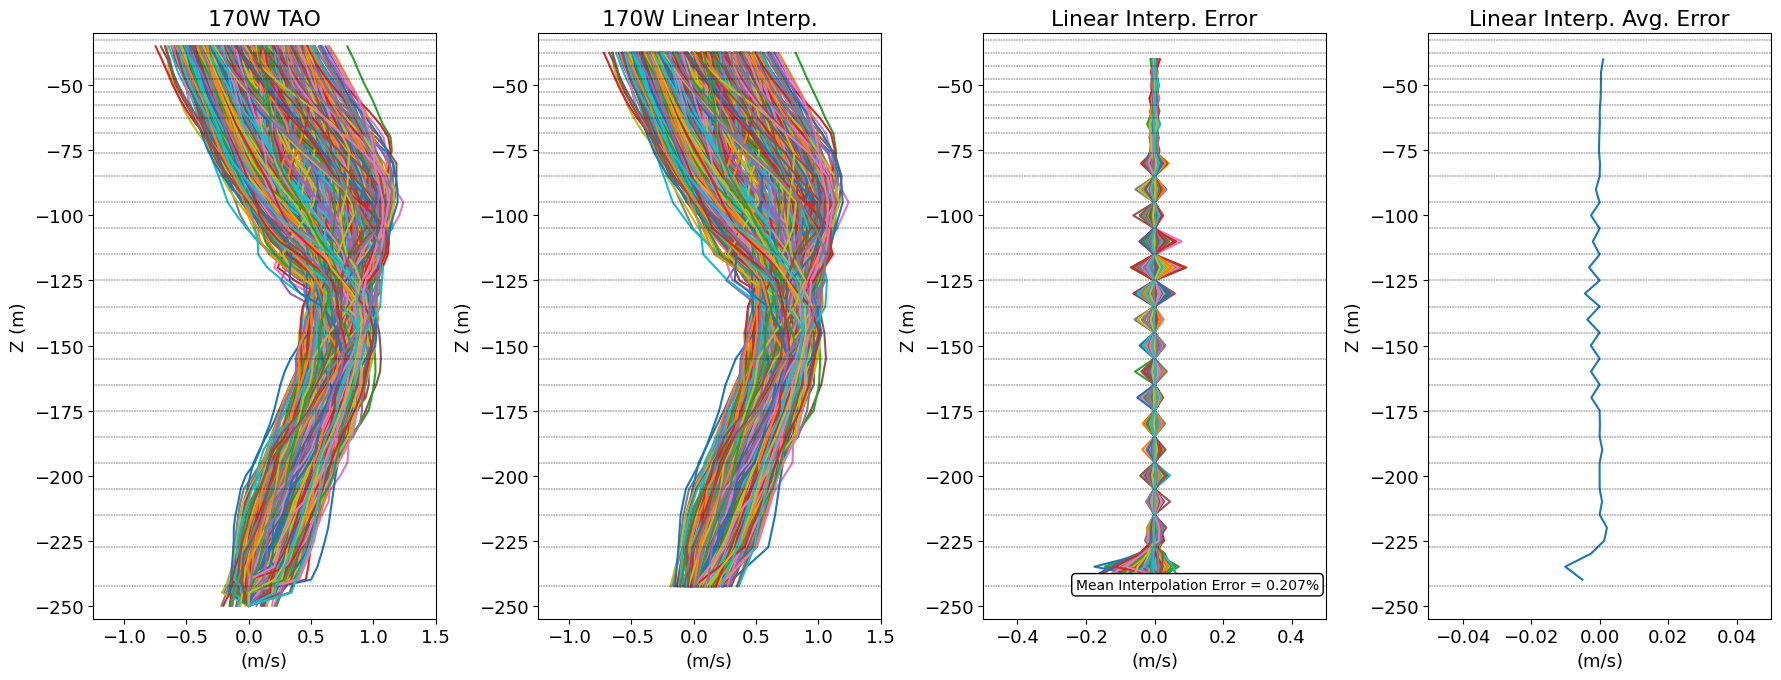

In [9]:
fig, ax = plt.subplots(figsize=(18, 7),ncols=4)
ax[0].plot(U6_TAO_170.T, U6_TAO_170.Z)
ax[0].set_title('170W TAO')
ax[0].set_xlabel('(m/s)') 
ax[0].set_ylabel('Z (m)')
ax[0].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[0].set_ylim(-255,-30)
ax[0].set_xlim(-1.25, 1.5)

ax[1].plot(U6_interp_170.T, U6_interp_170.Z)
ax[1].set_title('170W Linear Interp.')
ax[1].set_xlabel('(m/s)') 
ax[1].set_ylabel('Z (m)')
ax[1].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[1].set_ylim(-255,-30)
ax[1].set_xlim(-1.25, 1.5)

# now convert back to the same number of grid points as the original for comparison
U6_interp_170_grid = U6_interp_170.interp(Z=U6_TAO_170.Z.values, method='linear')

ax[2].plot((U6_interp_170_grid - U6_TAO_170).T, U6_interp_170_grid.Z)
ax[2].set_title('Linear Interp. Error')
ax[2].set_xlabel('(m/s)') 
ax[2].set_ylabel('Z (m)')
ax[2].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[2].set_ylim(-255,-30)
ax[2].set_xlim(-0.5, 0.5)


mean_err = np.nanmean((U6_interp_170_grid - U6_TAO_170).mean(dim='time'))/np.nanmean(U6_TAO_170)
interp_error = np.abs(mean_err) * 100.0
textstr = f"Mean Interpolation Error = {np.nanmean(interp_error):.3f}%"

# Add text box
ax[2].text(
    0.98, 0.05, textstr,
    transform=ax[2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0)
)

error = (U6_interp_170_grid - U6_TAO_170)
ax[3].plot(error.mean(dim='time'), U6_interp_170_grid.Z, color='tab:blue')
ax[3].fill_betweenx(U6_interp_170_grid.Z,error.mean(dim='time')-error.std(dim='time'),error.mean(dim='time')+error.std(dim='time'),color='tab:blue', alpha=0.25,label='_nolabel_')
ax[3].set_title('Linear Interp. Avg. Error')
ax[3].set_xlabel('(m/s)') 
ax[3].set_ylabel('Z (m)')
ax[3].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[3].set_ylim(-255,-30)
ax[3].set_xlim(-0.05, 0.05)

plt.tight_layout()
plt.savefig('ADCP_Profiles_170W_RandomSelection_WithLinearInterp_500.png')

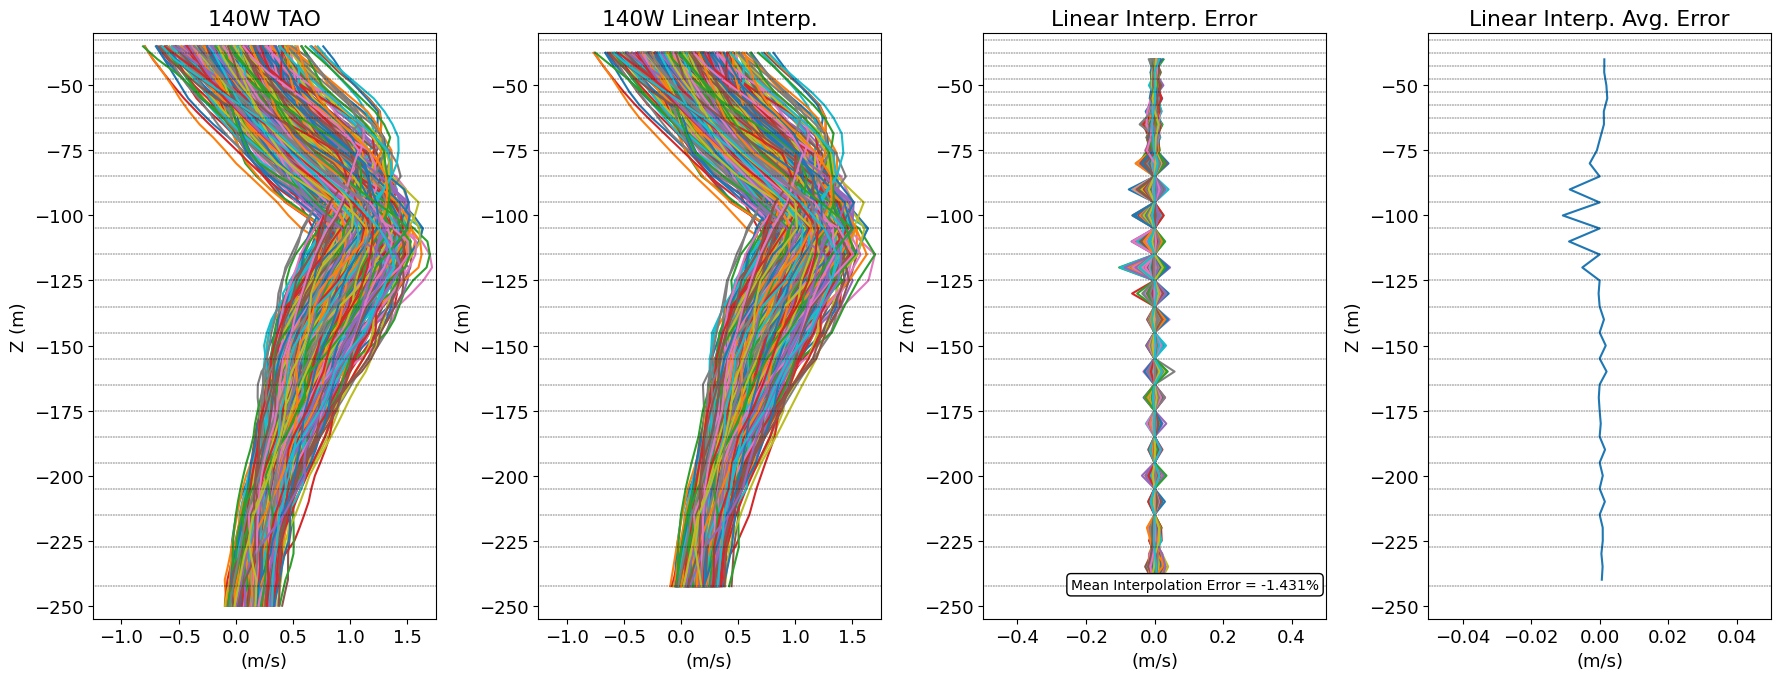

In [10]:
fig, ax = plt.subplots(figsize=(18, 7),ncols=4)
ax[0].plot(U6_TAO_140.T, U6_TAO_140.Z)
ax[0].set_title('140W TAO')
ax[0].set_xlabel('(m/s)') 
ax[0].set_ylabel('Z (m)')
ax[0].hlines(ds.Z.values, -1.5, 1.75, linewidth=0.35, color='k', linestyle='--')
ax[0].set_ylim(-255,-30)
ax[0].set_xlim(-1.25, 1.75)

ax[1].plot(U6_interp_140.T, U6_interp_140.Z)
ax[1].set_title('140W Linear Interp.')
ax[1].set_xlabel('(m/s)') 
ax[1].set_ylabel('Z (m)')
ax[1].hlines(ds.Z.values, -1.5, 1.75, linewidth=0.35, color='k', linestyle='--')
ax[1].set_ylim(-255,-30)
ax[1].set_xlim(-1.25, 1.75)

# now convert back to the same number of grid points as the original for comparison
U6_interp_140_grid = U6_interp_140.interp(Z=U6_TAO_140.Z.values, method='linear')

ax[2].plot((U6_interp_140_grid - U6_TAO_140).T, U6_interp_140_grid.Z)
ax[2].set_title('Linear Interp. Error')
ax[2].set_xlabel('(m/s)') 
ax[2].set_ylabel('Z (m)')
ax[2].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[2].set_ylim(-255,-30)
ax[2].set_xlim(-0.5, 0.5)

interp_error = (U6_interp_140_grid - U6_TAO_140)/U6_TAO_140 * 100.0
textstr = f"Mean Interpolation Error = {interp_error.mean():.3f}%"

# Add text box
ax[2].text(
    0.98, 0.05, textstr,
    transform=ax[2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0)
)


error = (U6_interp_140_grid - U6_TAO_140)
ax[3].plot(error.mean(dim='time'), U6_interp_140_grid.Z, color='tab:blue')
ax[3].fill_betweenx(U6_interp_140_grid.Z,error.mean(dim='time')-error.std(dim='time'),error.mean(dim='time')+error.std(dim='time'),color='tab:blue', alpha=0.25,label='_nolabel_')
ax[3].set_title('Linear Interp. Avg. Error')
ax[3].set_xlabel('(m/s)') 
ax[3].set_ylabel('Z (m)')
ax[3].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[3].set_ylim(-255,-30)
ax[3].set_xlim(-0.05, 0.05)

plt.tight_layout()
plt.savefig('ADCP_Profiles_140W_RandomSelection_WithLinearInterp_500.png')


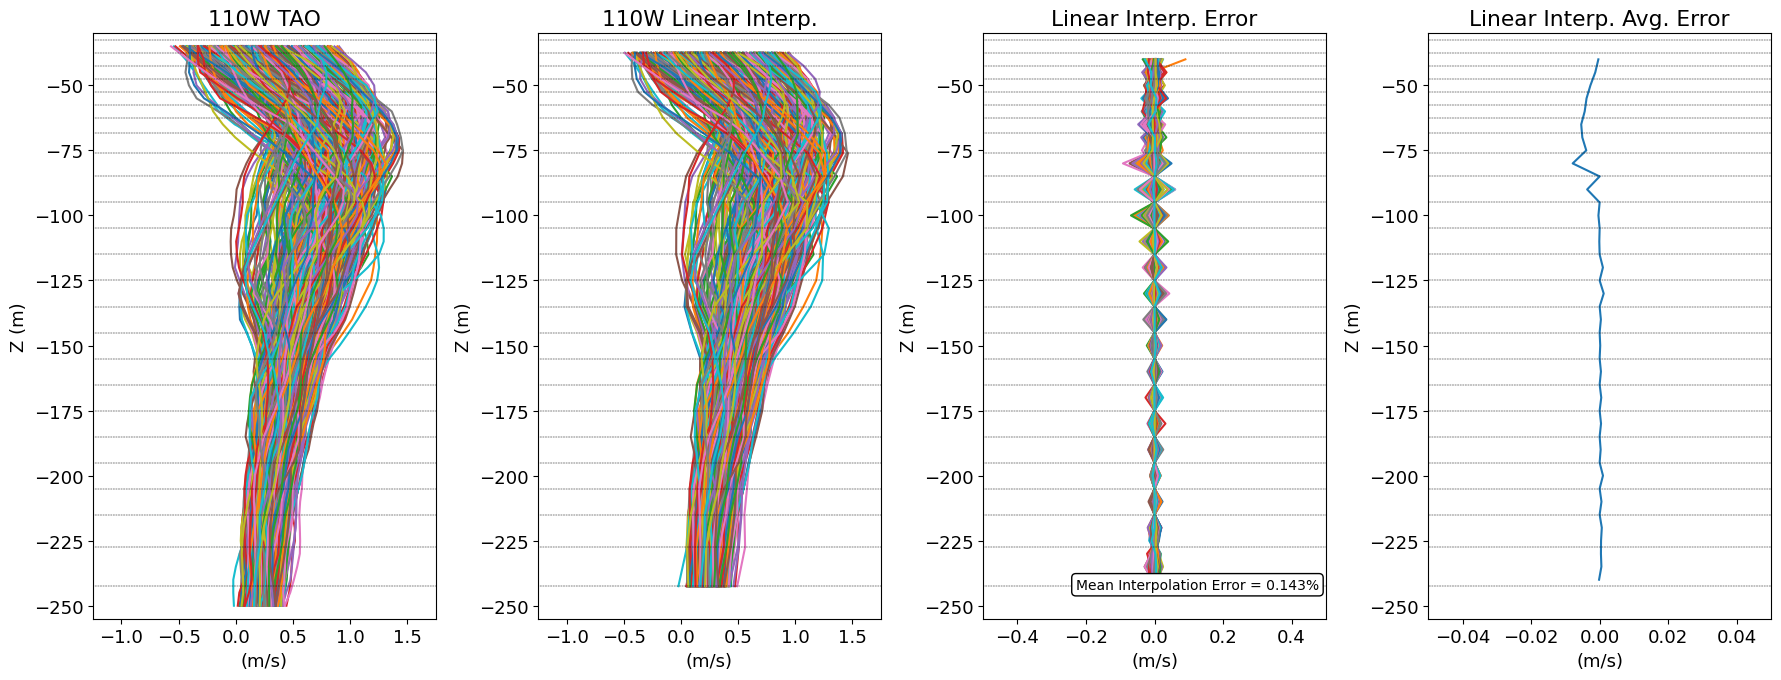

In [11]:
fig, ax = plt.subplots(figsize=(18, 7),ncols=4)
ax[0].plot(U6_TAO_110.T, U6_TAO_110.Z)
ax[0].set_title('110W TAO')
ax[0].set_xlabel('(m/s)') 
ax[0].set_ylabel('Z (m)')
ax[0].hlines(ds.Z.values, -1.5, 1.75, linewidth=0.35, color='k', linestyle='--')
ax[0].set_ylim(-255,-30)
ax[0].set_xlim(-1.25, 1.75)

ax[1].plot(U6_interp_110.T, U6_interp_110.Z)
ax[1].set_title('110W Linear Interp.')
ax[1].set_xlabel('(m/s)') 
ax[1].set_ylabel('Z (m)')
ax[1].hlines(ds.Z.values, -1.5, 1.75, linewidth=0.35, color='k', linestyle='--')
ax[1].set_ylim(-255,-30)
ax[1].set_xlim(-1.25, 1.75)

# now convert back to the same number of grid points as the original for comparison
U6_interp_110_grid = U6_interp_110.interp(Z=U6_TAO_110.Z.values, method='linear')

ax[2].plot((U6_interp_110_grid - U6_TAO_110).T, U6_interp_110_grid.Z)
ax[2].set_title('Linear Interp. Error')
ax[2].set_xlabel('(m/s)') 
ax[2].set_ylabel('Z (m)')
ax[2].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[2].set_ylim(-255,-30)
ax[2].set_xlim(-0.5, 0.5)

interp_error = (U6_interp_110_grid - U6_TAO_110)/U6_TAO_110 * 100.0
textstr = f"Mean Interpolation Error = {interp_error.mean():.3f}%"

# Add text box
ax[2].text(
    0.98, 0.05, textstr,
    transform=ax[2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0)
)

error = (U6_interp_110_grid - U6_TAO_110)
ax[3].plot(error.mean(dim='time'), U6_interp_110_grid.Z, color='tab:blue')
ax[3].fill_betweenx(U6_interp_110_grid.Z,error.mean(dim='time')-error.std(dim='time'),error.mean(dim='time')+error.std(dim='time'),color='tab:blue', alpha=0.25,label='_nolabel_')
ax[3].set_title('Linear Interp. Avg. Error')
ax[3].set_xlabel('(m/s)') 
ax[3].set_ylabel('Z (m)')
ax[3].hlines(ds.Z.values, -1.5, 1.5, linewidth=0.35, color='k', linestyle='--')
ax[3].set_ylim(-255,-30)
ax[3].set_xlim(-0.05, 0.05)


plt.tight_layout()
plt.savefig('ADCP_Profiles_110W_RandomSelection_WithLinearInterp_500.png')

In [ ]:
client.shutdown() 